# 0 - Set-Up

### Environment Set Up 

In [1]:
# Install required packages
!pip install -qq -r ../requirements.txt

# Set up root directory
import sys

REL_PATH_TO_ROOT = "../"

sys.path.insert(0,REL_PATH_TO_ROOT)

from src.utils import get_root_dir, test_root_dir
from local_variables import ROOT_DIR

test_root_dir(REL_PATH_TO_ROOT)

Root directory set up correctly!


In [2]:
# Get project questions
from questions.questions import questions as QQQQ

### Import Packages

In [3]:
# Import project specific packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from scipy.stats import mannwhitneyu
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

### Load Data

In [4]:
# Relevant files for AirBnB
files_of_interest = ["calendar.csv","listings.csv"]
years = ["2023","2024"]

In [5]:
# Concatenate for 2023 and 2024
cal_df = pd.concat([pd.read_csv(f"{get_root_dir()}/data/{year}_tokyo/calendar.csv") for year in years],ignore_index=True)

In [6]:
# Concatenate for 2023 and 2024
list_df = pd.concat([pd.read_csv(f"{get_root_dir()}/data/{year}_tokyo/listings.csv") for year in years],ignore_index=True)

/tmp/ipykernel_606/1614946570.py:2: DtypeWarning: Columns (59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  list_df = pd.concat([pd.read_csv(f"{get_root_dir()}/data/{year}_tokyo/listings.csv") for year in years],ignore_index=True)


In [7]:
# Data for the first bloom of the cherry blossoms
first_bloom = pd.read_csv(f"{get_root_dir()}/data/cherry_blossom_dates/sakura_first_bloom_dates.csv")
first_bloom.columns = first_bloom.columns.str.lower().str.replace(" ","_")

In [8]:
# Data for the full bloom of the cherry blossoms
full_bloom = pd.read_csv(f"{get_root_dir()}/data/cherry_blossom_dates/sakura_full_bloom_dates.csv")
full_bloom.columns = full_bloom.columns.str.lower().str.replace(" ","_")

In [9]:
# Print out questions
def get_question(question_num):
    print(QQQQ[question_num])

for i in range(1,5):
    get_question(str(i))

Q1: How much do neighbourhoods affect the price of AirBnbs?
Q2: 花見 (hanami) is the Japanese practice of watching cherry blossoms bloom, in Japan due to a previous blight among the tree population around 80% of cherry blossoms are genetically identical meaning the vast majority will bloom under the same conditions. Forecasts exist and are well known, for the date of mass blooming. Does the date of blooming seem to impact the price?
Q3: Which features of the dataset have the best predictive power for the price of a propert based on logistic regression?
Q4 : What are the features that best predict superhost status?


# 1 - Initial EDA

## 1.1 - High-Level View - Calendar

### 1.1.1 - Data Structure

In [10]:
cal_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,197677,2023-06-29,f,"$11,000.00","$11,000.00",3.0,1125.0
1,197677,2023-06-30,f,"$11,000.00","$11,000.00",3.0,1125.0
2,197677,2023-07-01,f,"$11,000.00","$11,000.00",3.0,1125.0
3,197677,2023-07-02,f,"$11,000.00","$11,000.00",3.0,1125.0
4,197677,2023-07-03,f,"$11,000.00","$11,000.00",3.0,1125.0


In [11]:
print("Each row corresponds to one data and one property based on the listing id")

Each row corresponds to one data and one property based on the listing id


In [12]:
#Number of unique properties
cal_df["listing_id"].nunique()

18924

### 1.1.2 - Date Range

<Axes: xlabel='date_dt'>

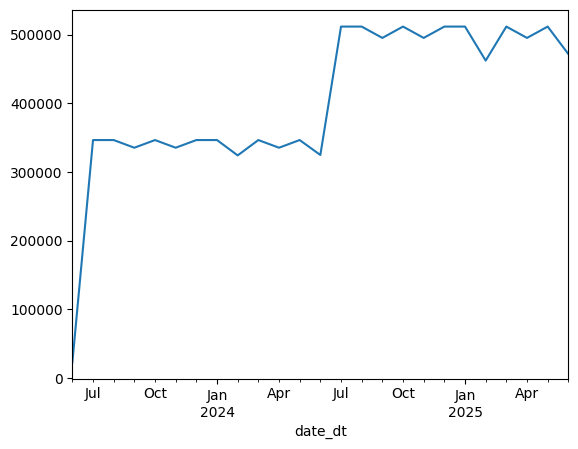

In [13]:
#Time range
cal_df["date_dt"] = pd.to_datetime(cal_df["date"])
cal_df["date_dt"].dt.to_period('M').value_counts().sort_index().plot(kind='line')

In [14]:
# See the shape of the datafram
cal_df.shape[0]

10101939

In [15]:
# Jump in counts for 2024-07, are there duplicates?
dropped_dups = cal_df.drop_duplicates()

In [16]:
dropped_dups.shape[0]

10101939

In [17]:
print("No duplicates found as counts the same")

No duplicates found as counts the same


### 1.1.3 - Price Distribution

In [18]:
# Turn price string into a number
cal_df["price_num"] = cal_df["price"].str.replace("$","")
cal_df["price_num"] = cal_df["price_num"].str.replace(",","")
cal_df["price_num"] = cal_df["price_num"].astype(float)

<Axes: xlabel='price_num', ylabel='Count'>

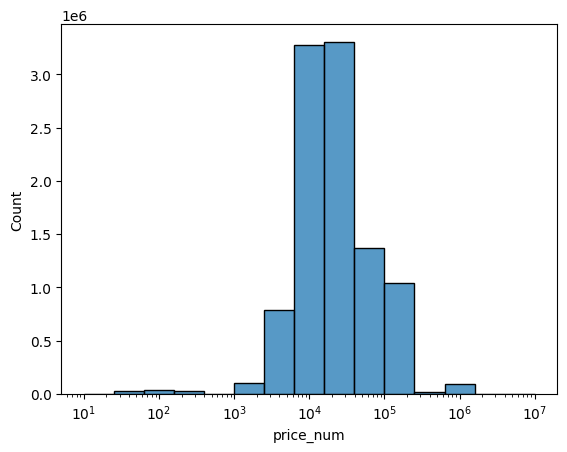

In [19]:
# Plot distribution (use log scale due to wide variation of values)
sns.histplot(data=cal_df,x="price_num",log_scale=True,bins=15)

### 1.1.4 - Average Prices Over Time

In [20]:
def average_x_time_plot(df, datefield, x, show_percentiles=False, percentile=0.95, group_var=None, log_scale=True):
    """
    Plots the average of a specified column (`x`) over time, with options for percentile bounds 
    and grouping by an additional variable.

    Parameters:
    ----------
    df : pandas.DataFrame
        The input DataFrame containing the data to be plotted.
    datefield : str
        The name of the column representing dates.
    x : str
        The column for which averages are computed and plotted.
    show_percentiles : bool, optional, default=False
        Whether to display percentile bounds on the plot. 
        If True, shaded areas showing percentile bounds are added.
    percentile : float, optional, default=0.95
        The desired percentile range to display if `show_percentiles` is True. 
        For example, 0.95 corresponds to a 95% percentile range.
    group_var : str or None, optional, default=None
        An optional column for grouping the data. Separate lines and percentile bounds are plotted 
        for each unique value in this column if provided.
    log_scale : bool, optional, default=True
        Whether to apply a natural logarithm transformation to the averages and bounds 
        before plotting.

    Returns:
    -------
    None
        The function generates and displays the plot.

    Notes:
    ------
    - If `log_scale` is True, the y-axis will represent the log-transformed values of `x`.
    - When `show_percentiles` is True and `group_var` is provided, separate shaded areas 
      representing the percentile range are plotted for each group.
    - The function uses Seaborn for line plotting and Matplotlib for additional styling.

    Example:
    --------
    average_x_time_plot(
        df=my_data, 
        datefield="date", 
        x="value", 
        show_percentiles=True, 
        percentile=0.9, 
        group_var="category", 
        log_scale=False
    )
    """

    # Copy dataframe to avoid making changes
    work_df = df.copy(deep=False)

    # Convert data column to DT format
    work_df[datefield] = pd.to_datetime(work_df[datefield])

    # Set grouping variables depending on inputs
    if group_var == None:
        group_fields = datefield
    else:
        group_fields = [datefield,group_var]

    # Get the summary stats depending on whether upper or lower bounds were wanted
    if show_percentiles:
        perc = 1-percentile
        summary_stats = work_df.groupby(group_fields)[x].agg(avg='mean',lower_bound=lambda x: x.quantile(perc/2),
    upper_bound=lambda x: x.quantile(1-perc/2)).reset_index()
    else:
        summary_stats = work_df.groupby(group_fields)[x].agg(avg='mean').reset_index()

    # Create necessary transformed variables depending on log_scale argument 
    if log_scale:
        summary_stats[f"log_{x}"] = np.log(summary_stats['avg'])
        if show_percentiles:
            summary_stats['log_lower_bound'] = np.log(summary_stats['lower_bound'])
            summary_stats['log_upper_bound'] = np.log(summary_stats['upper_bound'])

    # Create plot
    plt.figure(figsize=(12, 6))

    # Create a palette to keep colouring of bounds consistent with the line plot
    sns_palette = sns.color_palette(n_colors=summary_stats[group_var].nunique() if group_var else 1)

    # Plot lineplot of date against (log) of average x over time
    sns.lineplot(data=summary_stats, x=summary_stats[datefield],y=f"log_{x}" if log_scale else 'avg',hue=group_var, linewidth=2,palette=sns_palette)

    # Create bound plots if requested
    if show_percentiles and group_var:
        for color, (group, group_data) in zip(sns_palette, summary_stats.groupby(group_var)):
            plt.fill_between(
                group_data[datefield],
                group_data['log_lower_bound'] if log_scale else group_data['lower_bound'],
                group_data['log_upper_bound'] if log_scale else group_data['upper_bound'],
                alpha=0.2,
                color=color,
                label=f'{group} {100 * percentile}% Percentile Range'
            )

    elif show_percentiles:  # For no group_var, single fill_between
        plt.fill_between(
            summary_stats[datefield],
            summary_stats['log_lower_bound'] if log_scale else summary_stats['lower_bound'],
            summary_stats['log_upper_bound'] if log_scale else summary_stats['upper_bound'],
            alpha=0.3,
            color=sns_palette[0],
            label=f'{100 * percentile}% Percentile Range'
        )
    
    plt.xlabel('Date')
    plt.ylabel(f'Log ')
    plt.title(f'Average {'Log ' if log_scale else ""}{x.capitalize()} Over Time with {100*percentile}% Percentile Bounds')
    plt.legend()
    plt.show()

/tmp/ipykernel_606/4222415178.py:86: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=summary_stats, x=summary_stats[datefield],y=f"log_{x}" if log_scale else 'avg',hue=group_var, linewidth=2,palette=sns_palette)


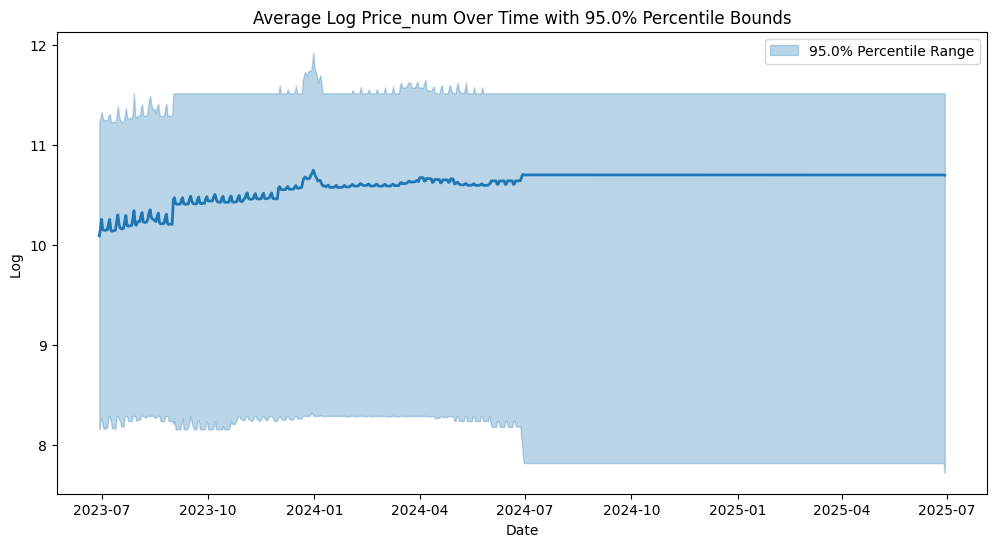

In [21]:
# Plot average log price over time
average_x_time_plot(cal_df,"date","price_num",show_percentiles=True)

In [22]:
print("Huge variability in the price at a given time, what determines the price?")

Huge variability in the price at a given time, what determines the price?


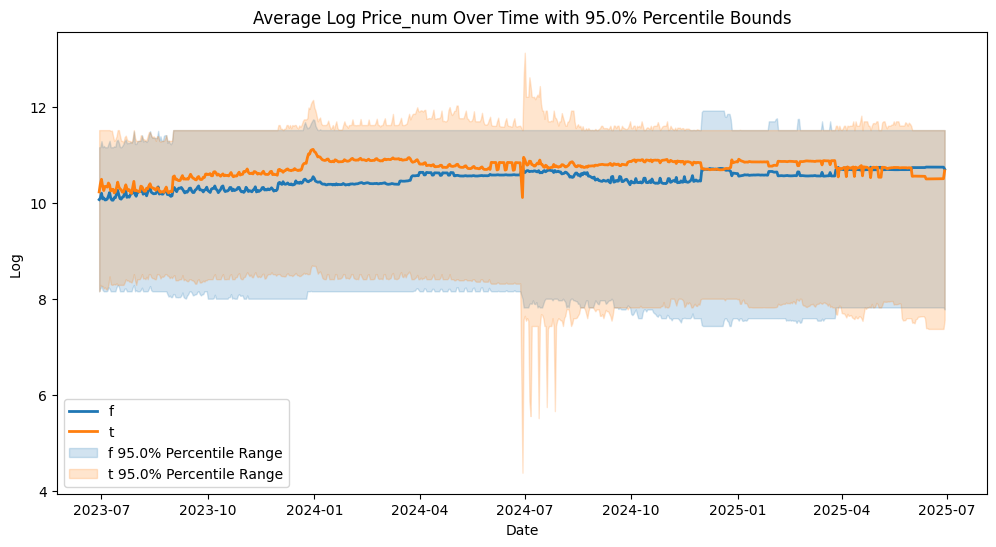

In [23]:
# Look at availability for price 
average_x_time_plot(cal_df,"date","price_num",show_percentiles=True,group_var="available")

In [24]:
print("Doesn't seem to make a huge difference, although unoccupied properties tend to be priced lower")

Doesn't seem to make a huge difference, although unoccupied properties tend to be priced lower


In [25]:
# Look at availability for price 
plot_1_df = cal_df[cal_df["maximum_nights"] <= 31]
plot_2_df = cal_df[~(cal_df["maximum_nights"] <= 31)]

/tmp/ipykernel_606/2620749242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_1_df['maximum_nights_group'] = pd.qcut(plot_1_df['maximum_nights'], q=4,duplicates="drop")
/tmp/ipykernel_606/4222415178.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = work_df.groupby(group_fields)[x].agg(avg='mean').reset_index()


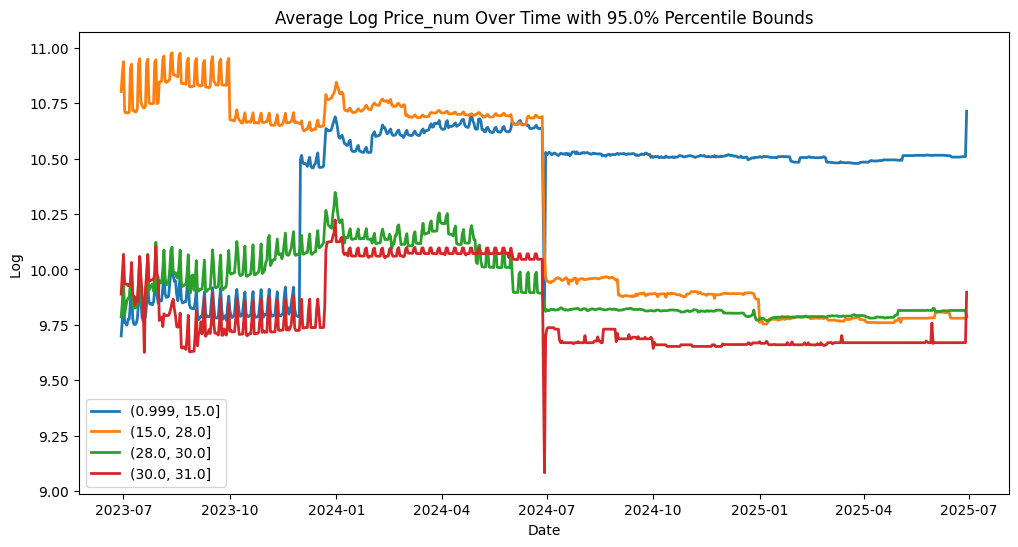

In [26]:
# Split into groups of roughly equal sizes and plot
plot_1_df['maximum_nights_group'] = pd.qcut(plot_1_df['maximum_nights'], q=4,duplicates="drop")
average_x_time_plot(plot_1_df,"date","price_num",show_percentiles=False,group_var="maximum_nights_group")

In [27]:
print("Seems that smaller maximum stays are generally more expensive, while maximum stays after a certain point are more comparable. Huge drop and rebound in 2024-07 may correspond to the large depreciation of the Yen (-8% agains the dollar) which occurred early July")

Seems that smaller maximum stays are generally more expensive, while maximum stays after a certain point are more comparable. Huge drop and rebound in 2024-07 may correspond to the large depreciation of the Yen (-8% agains the dollar) which occurred early July


/tmp/ipykernel_606/3772240745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_2_df['maximum_nights_group'] = pd.qcut(plot_2_df['maximum_nights'], q=5,duplicates="drop")
/tmp/ipykernel_606/4222415178.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = work_df.groupby(group_fields)[x].agg(avg='mean').reset_index()


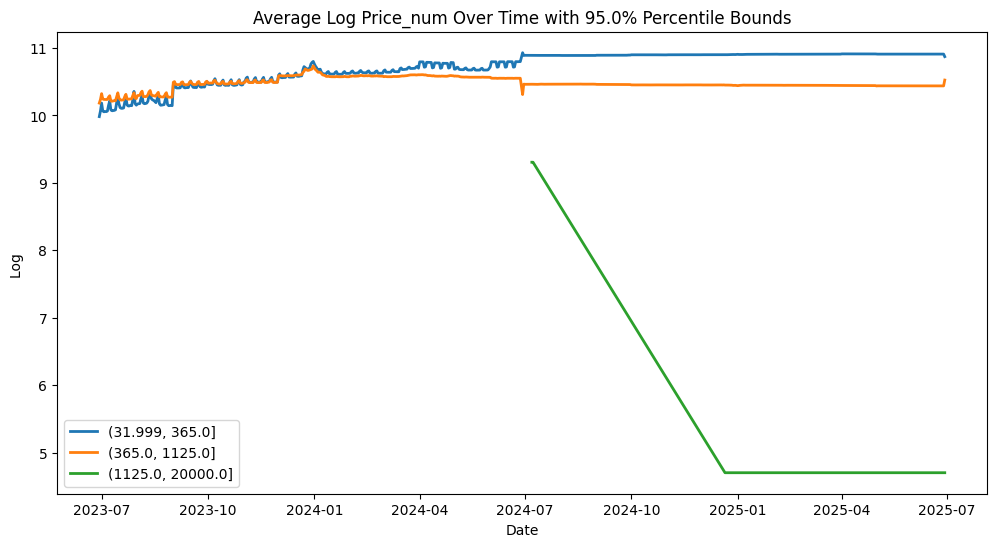

In [28]:
# Do the same for maximum nights
plot_2_df['maximum_nights_group'] = pd.qcut(plot_2_df['maximum_nights'], q=5,duplicates="drop")
average_x_time_plot(plot_2_df,"date","price_num",show_percentiles=False,group_var="maximum_nights_group")

In [29]:
print("Properties with a likely placeholder maximum stay seem to have a precipitous decline for projected prices")

Properties with a likely placeholder maximum stay seem to have a precipitous decline for projected prices


In [30]:
cal_df.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights', 'date_dt', 'price_num'],
      dtype='object')

/tmp/ipykernel_606/1980759731.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_1_df['minimum_nights_group'] = pd.qcut(plot_1_df['minimum_nights'], q=3,duplicates="drop")
/tmp/ipykernel_606/4222415178.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = work_df.groupby(group_fields)[x].agg(avg='mean').reset_index()


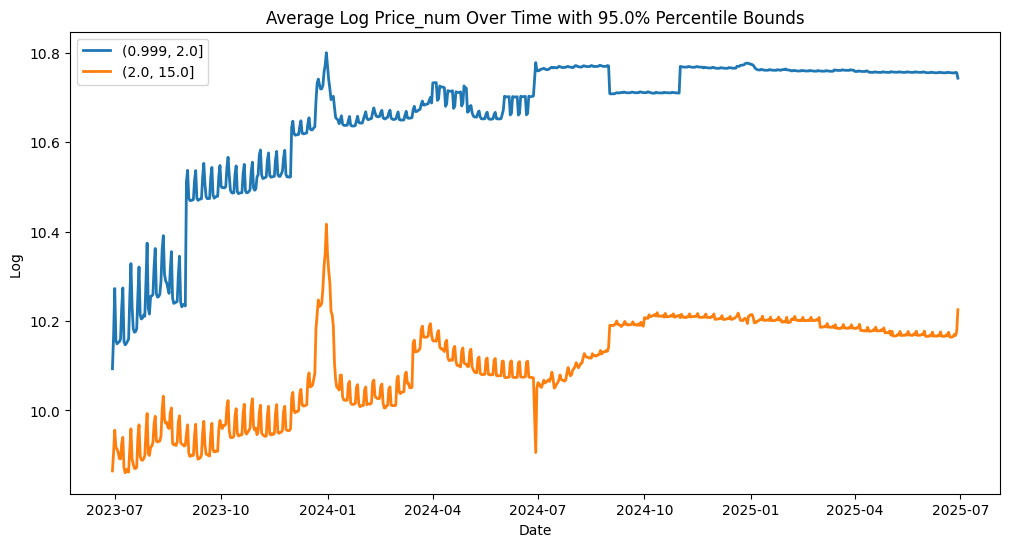

In [31]:
# Focus more on shorter nights
plot_1_df = cal_df[cal_df["minimum_nights"] <= 15]
plot_1_df['minimum_nights_group'] = pd.qcut(plot_1_df['minimum_nights'], q=3,duplicates="drop")
average_x_time_plot(plot_1_df,"date","price_num",show_percentiles=False,group_var="minimum_nights_group")

In [32]:
print("Seems to be a difference but not huge in size")

Seems to be a difference but not huge in size


/tmp/ipykernel_606/3876419914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_2_df['minimum_nights_group'] = pd.qcut(plot_2_df['minimum_nights'], q=3,duplicates="drop")
/tmp/ipykernel_606/4222415178.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = work_df.groupby(group_fields)[x].agg(avg='mean').reset_index()


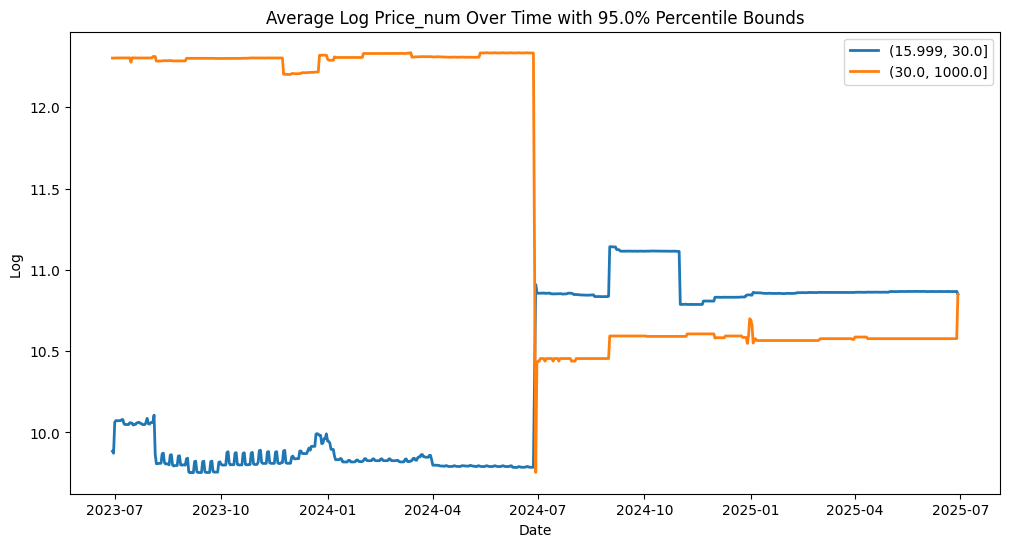

In [33]:
# Now look at the opposite groups
plot_2_df = cal_df[~(cal_df["minimum_nights"] <= 15)]
plot_2_df['minimum_nights_group'] = pd.qcut(plot_2_df['minimum_nights'], q=3,duplicates="drop")
average_x_time_plot(plot_2_df,"date","price_num",show_percentiles=False,group_var="minimum_nights_group")

In [34]:
print("Seems to be a huge difference for before 07")

Seems to be a huge difference for before 07


## 1.2 - Listings

In [35]:
# View columns in the listings dataframe which provides more information on individual hosts 
list_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [36]:
list_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20230629055629,2023-06-29,city scrape,Rental unit in Sumida · ★4.78 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.21
1,776070,https://www.airbnb.com/rooms/776070,20230629055629,2023-06-29,city scrape,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,...,4.98,4.83,4.91,NaN,f,1,0,1,0,1.89
2,905944,https://www.airbnb.com/rooms/905944,20230629055629,2023-06-29,city scrape,Rental unit in Shibuya · ★4.76 · 2 bedrooms · ...,NEWLY RENOVATED property entirely for you & yo...,Hatagaya is a great neighborhood located 4 min...,https://a0.muscache.com/pictures/miso/Hosting-...,4847803,...,4.90,4.77,4.77,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,t,5,5,0,0,1.49
3,1016831,https://www.airbnb.com/rooms/1016831,20230629055629,2023-06-29,city scrape,Home in Setagaya · ★4.94 · 1 bedroom · 2 beds ...,"Hi there, I am Wakana and I live with my two f...",The location is walkable distance to famous Sh...,https://a0.muscache.com/pictures/airflow/Hosti...,5596383,...,4.98,4.92,4.89,NaN,f,1,0,1,0,1.96
4,1196177,https://www.airbnb.com/rooms/1196177,20230629055629,2023-06-29,city scrape,Home in 足立区 · ★4.71 · 1 bedroom · 1.5 shared b...,Ｓtay with host.We can help your travel.<br />B...,There are shopping mall near Senjuohashi stati...,https://a0.muscache.com/pictures/72890882/05ec...,5686404,...,4.88,4.67,4.75,NaN,f,1,0,1,0,0.79


In [37]:
print("Unique to id and last_scraped level")

Unique to id and last_scraped level


### 1.2.1 - Time Structure in Dataframe

In [38]:
# Get a list of ids
test_ids = list_df["id"].head().values

In [39]:
# See how things change over time
list_df[list_df["id"].isin(test_ids)].sort_values(by="id")

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20230629055629,2023-06-29,city scrape,Rental unit in Sumida · ★4.78 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.21
11177,197677,https://www.airbnb.com/rooms/197677,20240629155511,2024-06-30,city scrape,Oshiage Holiday Apartment,NaN,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.83,4.54,4.79,M130003350,f,1,1,0,0,1.13
11178,776070,https://www.airbnb.com/rooms/776070,20240629155511,2024-06-29,city scrape,Kero-kero house room 1,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,...,4.98,4.84,4.92,M130000243,f,1,0,1,0,1.81
1,776070,https://www.airbnb.com/rooms/776070,20230629055629,2023-06-29,city scrape,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,...,4.98,4.83,4.91,NaN,f,1,0,1,0,1.89
11179,905944,https://www.airbnb.com/rooms/905944,20240629155511,2024-06-30,city scrape,4F - Near Shinjuku & Shibuya,NEWLY RENOVATED property entirely for you & yo...,Hatagaya is a great neighborhood located 4 min...,https://a0.muscache.com/pictures/miso/Hosting-...,4847803,...,4.91,4.79,4.79,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,t,6,6,0,0,1.60
2,905944,https://www.airbnb.com/rooms/905944,20230629055629,2023-06-29,city scrape,Rental unit in Shibuya · ★4.76 · 2 bedrooms · ...,NEWLY RENOVATED property entirely for you & yo...,Hatagaya is a great neighborhood located 4 min...,https://a0.muscache.com/pictures/miso/Hosting-...,4847803,...,4.90,4.77,4.77,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,t,5,5,0,0,1.49
3,1016831,https://www.airbnb.com/rooms/1016831,20230629055629,2023-06-29,city scrape,Home in Setagaya · ★4.94 · 1 bedroom · 2 beds ...,"Hi there, I am Wakana and I live with my two f...",The location is walkable distance to famous Sh...,https://a0.muscache.com/pictures/airflow/Hosti...,5596383,...,4.98,4.92,4.89,NaN,f,1,0,1,0,1.96
11180,1016831,https://www.airbnb.com/rooms/1016831,20240629155511,2024-06-29,city scrape,5 mins Shibuya Cat modern sunny Shimokita,"Hi there, I am Wakana and I live with my two f...",The location is walkable distance to famous Sh...,https://a0.muscache.com/pictures/airflow/Hosti...,5596383,...,4.98,4.92,4.90,M130001107,f,2,1,1,0,1.96
4,1196177,https://www.airbnb.com/rooms/1196177,20230629055629,2023-06-29,city scrape,Home in 足立区 · ★4.71 · 1 bedroom · 1.5 shared b...,Ｓtay with host.We can help your travel.<br />B...,There are shopping mall near Senjuohashi stati...,https://a0.muscache.com/pictures/72890882/05ec...,5686404,...,4.88,4.67,4.75,NaN,f,1,0,1,0,0.79
11181,1196177,https://www.airbnb.com/rooms/1196177,20240629155511,2024-06-29,city scrape,Stay with host Cozy private room Senju area,Ｓtay with host.We can help your travel.<br />B...,There are shopping mall near Senjuohashi stati...,https://a0.muscache.com/pictures/72890882/05ec...,5686404,...,4.91,4.73,4.80,M130007760,f,1,0,1,0,0.91


In [40]:
# How many listings have data for both years?
list_df["id"].value_counts().reset_index()["count"].value_counts(normalize=True)

count
1    0.536901
2    0.463099
Name: proportion, dtype: float64

In [41]:
print("Around 50% only appear for one year")

Around 50% only appear for one year


In [42]:
# Create average price table 
average_prices = cal_df[["listing_id","price_num"]].groupby(by="listing_id",as_index=False).agg("mean")

### 1.2.2 - Review Data

<Axes: >

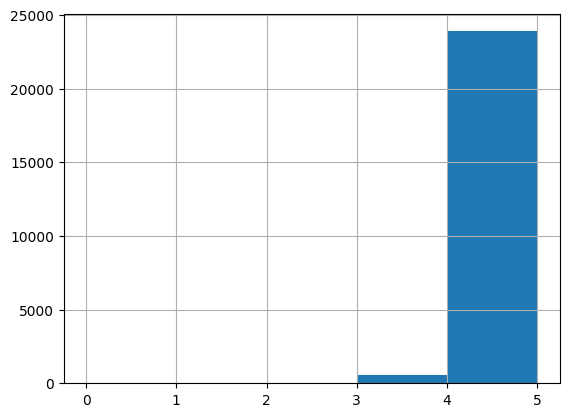

In [43]:
# Plot histogram for review rating
list_df["review_scores_rating"].hist(bins=5)

<Axes: >

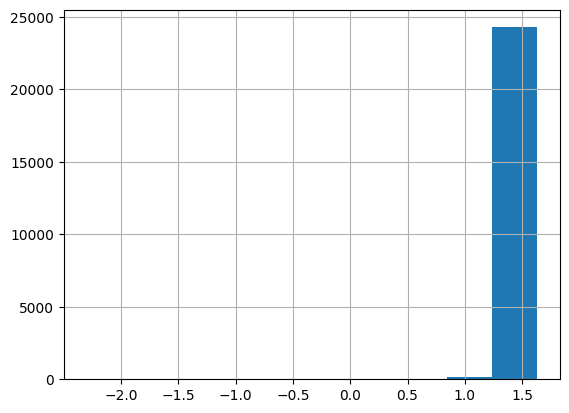

In [44]:
# Take log to spread out distribution a bit more, add offset for reviews of 0
np.log(list_df["review_scores_rating"]+0.1).hist(bins=10)

In [45]:
# What % of reviews are null? 
list_df["review_scores_rating"].isna().mean()

np.float64(0.1145694168622495)

In [46]:
# Compare reviews and prices
stars_and_prices = pd.merge(left=average_prices,right=list_df[["id","review_scores_rating"]].rename(columns={"id":"listing_id"}),how="inner",on="listing_id")

<Axes: xlabel='review_scores_rating', ylabel='price_num'>

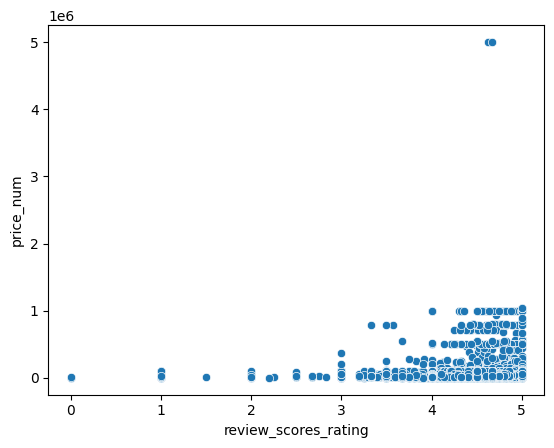

In [47]:
sns.scatterplot(data=stars_and_prices,x="review_scores_rating",y="price_num")

<Axes: xlabel='review_scores_rating', ylabel='price_num'>

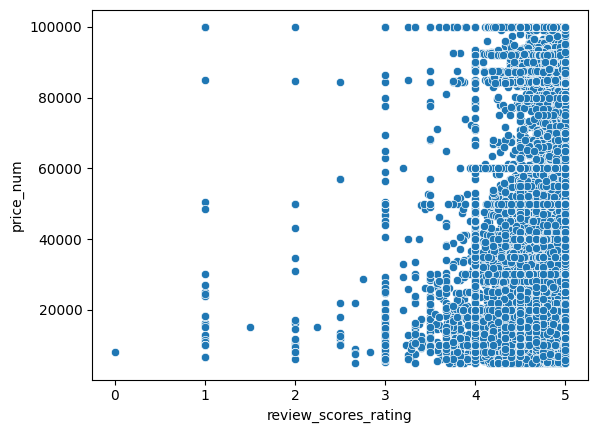

In [48]:
# Let's remove outliers on price

lower_quantile = 0.05
upper_quantile = 0.95

# Calculate the lower and upper bounds
price_lower = stars_and_prices['price_num'].quantile(lower_quantile)
price_upper = stars_and_prices['price_num'].quantile(upper_quantile)

# Filter the data to remove outliers
filtered_data = stars_and_prices[
    (stars_and_prices['price_num'] >= price_lower) &
    (stars_and_prices['price_num'] <= price_upper)
]


sns.scatterplot(data=filtered_data,x="review_scores_rating",y="price_num")


In [49]:
print("Still quite a lot of variability, hard to spot a trend from the visualisation")

Still quite a lot of variability, hard to spot a trend from the visualisation


### 1.2.3 - Room Type

In [50]:
roomgen_and_price = pd.merge(left=average_prices,right=list_df[["id","room_type"]].rename(columns={"id":"listing_id"}),how="inner",on="listing_id")

<Axes: xlabel='room_type', ylabel='price_num'>

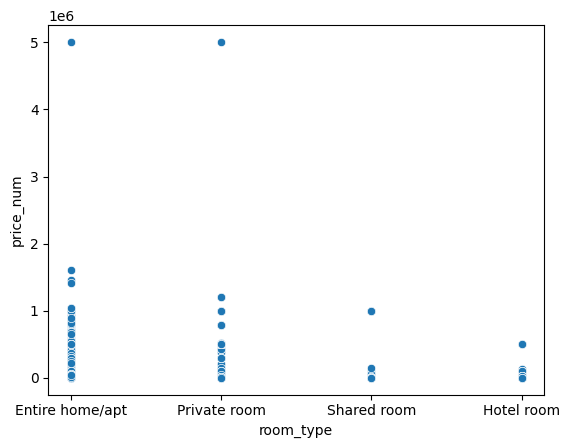

In [51]:
sns.scatterplot(data=roomgen_and_price,x="room_type",y="price_num")

<Axes: xlabel='room_type', ylabel='price_num'>

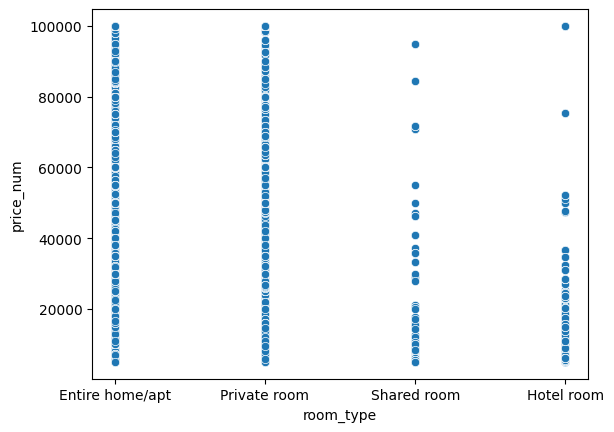

In [52]:
# Let's remove outliers on price

lower_quantile = 0.05
upper_quantile = 0.95

# Calculate the lower and upper bounds
price_lower = roomgen_and_price['price_num'].quantile(lower_quantile)
price_upper = roomgen_and_price['price_num'].quantile(upper_quantile)

# Filter the data to remove outliers
filtered_data = roomgen_and_price[
    (roomgen_and_price['price_num'] >= price_lower) &
    (roomgen_and_price['price_num'] <= price_upper)
]


sns.scatterplot(data=filtered_data,x="room_type",y="price_num")


In [53]:
print("Different distributions for each, seems to suggest shared rooms and hotel rooms are generally cheaper though")

Different distributions for each, seems to suggest shared rooms and hotel rooms are generally cheaper though


### 1.2.4 - Number of Rooms

In [54]:
# Compare averages and bedrooms
price_room_df = pd.merge(left=average_prices,right=list_df[["id","bedrooms"]].rename(columns={"id":"listing_id"}),how="inner",on="listing_id")

In [55]:
# Set percentage (bottom and top quartlies to visualise)
perc=0.05

# Perform aggregation for the bedroom level
price_by_room_df = price_room_df[["bedrooms","price_num"]].groupby(by="bedrooms",as_index=True)["price_num"].agg(avg_price="mean",lower_bound=lambda x: x.quantile(perc/2),
    upper_bound=lambda x: x.quantile(1-perc/2)).reset_index()

In [56]:
price_by_room_df.head()

,bedrooms,avg_price,lower_bound,upper_bound
0,0.0,59918.766249,4972.500000,109784.942466
1,1.0,39281.276267,3551.563699,100000.000000
2,2.0,40852.241533,8052.739726,113569.917808
3,3.0,48524.552416,10793.972603,161929.691781
4,4.0,55465.194148,13085.154110,194227.397260


<Axes: xlabel='bedrooms', ylabel='avg_price'>

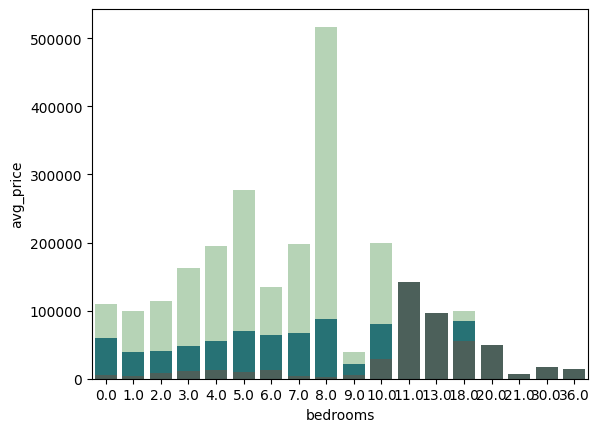

In [57]:
# Plot average prices with quartiles for listings with different no. beds
sns.barplot(data=price_by_room_df.sort_values(by="bedrooms",ascending=True),x="bedrooms",y="avg_price")
sns.barplot(data=price_by_room_df.sort_values(by="bedrooms",ascending=True),x="bedrooms",y="lower_bound",color='r',alpha=0.3)
sns.barplot(data=price_by_room_df.sort_values(by="bedrooms",ascending=True),x="bedrooms",y="upper_bound",color='g',alpha=0.3)

In [58]:
print("Bedrooms seems to have some correlation to price for less than 5 bedrooms, perhaps 6 bedrooms represent hostels etc.")

Bedrooms seems to have some correlation to price for less than 5 bedrooms, perhaps 6 bedrooms represent hostels etc.


In [59]:
list_df["bedrooms"].value_counts().reset_index().sort_values(by="bedrooms",ascending=True)

,bedrooms,count
3,0.0,1019
0,1.0,17508
1,2.0,3989
2,3.0,1890
4,4.0,732
5,5.0,209
6,6.0,69
7,7.0,31
8,8.0,24
10,9.0,6


### 1.2.5 - Neighbourhood

In [60]:
# Number of unique neighbourhood values
list_df["neighbourhood"].nunique()

412

In [61]:
# How many in the cleansed column?
list_df["neighbourhood_cleansed"].nunique()

49

In [62]:
print("Cleansed column seems to be the most appropriate to look at neighbourhoods")

Cleansed column seems to be the most appropriate to look at neighbourhoods


In [63]:
# Get average prices and neighbourhoods for listing 
neighbourhood_price_df = pd.merge(left=average_prices,right=list_df[["id","neighbourhood_cleansed"]].rename(columns={"id":"listing_id"}),how="inner",on="listing_id")

In [64]:
# Group by neighbourhood
price_by_neigh_df = neighbourhood_price_df.groupby("neighbourhood_cleansed",as_index=False).agg("mean")

In [65]:
def neighbourhood_name_tider(neighbourhood):
    '''Function to tidy up neighbourhood names for plots'''
    for redundant_text in [' Ku',' Mura',' Shi']:
        if redundant_text in neighbourhood:
            neighbourhood=neighbourhood.replace(redundant_text,"")
    return neighbourhood

In [66]:
# Tidy up names for a plot
price_by_neigh_df["tidier_neighbourhood_name"] = price_by_neigh_df["neighbourhood_cleansed"].apply(neighbourhood_name_tider)

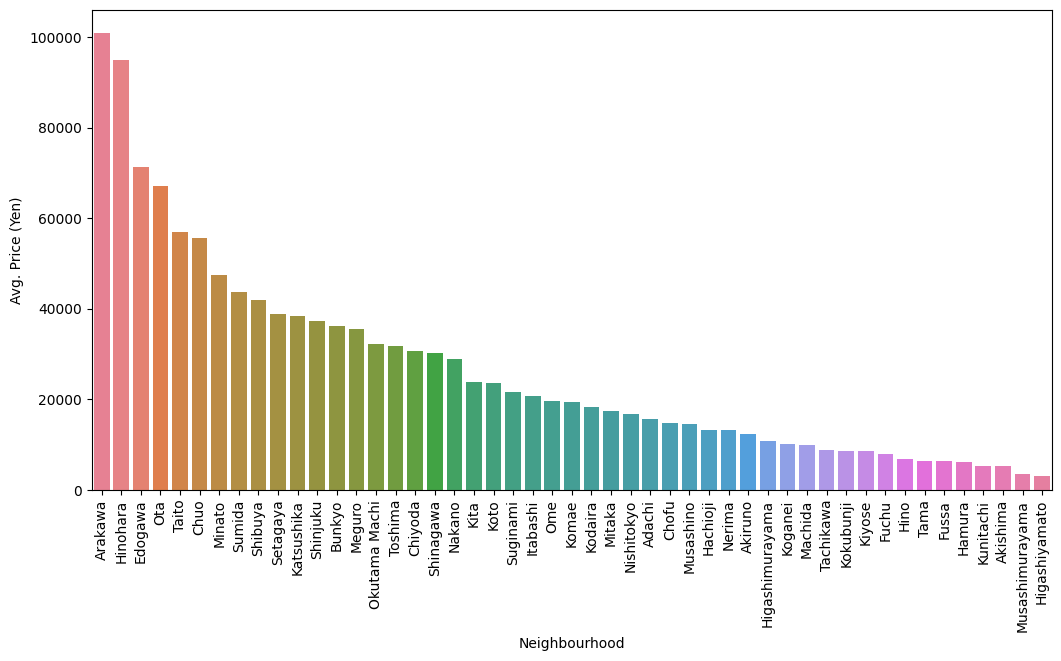

In [67]:
plt.figure(figsize=(12, 8))  # Increase the figure size for more white space
sns.barplot(
    data=price_by_neigh_df.sort_values(by="price_num", ascending=False),
    x="tidier_neighbourhood_name",
    y="price_num",
    hue="tidier_neighbourhood_name"
)
plt.xticks(rotation=90)
plt.ylabel("Avg. Price (Yen)")
plt.xlabel("Neighbourhood")

# Adjust subplot to add more white space around the plot
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)

# Save the plot
plt.savefig(f"{get_root_dir()}/data/image_1.png")
plt.show()

In [68]:
price_by_neigh_df[["tidier_neighbourhood_name","price_num"]].sort_values(by="price_num",ascending=False)

,tidier_neighbourhood_name,price_num
3,Arakawa,100976.315925
16,Hinohara,95000.000000
8,Edogawa,71322.342832
38,Ota,67086.206757
46,Taito,57052.298425
7,Chuo,55711.954748
29,Minato,47502.923549
44,Sumida,43693.547430
40,Shibuya,41930.298148
39,Setagaya,38914.844438


In [69]:
print("Neighbourhood seems to have a big impact on price")

Neighbourhood seems to have a big impact on price


In [70]:
neighbourhood_price_df["tidied_neighbourhood"] = neighbourhood_price_df["neighbourhood_cleansed"].apply(neighbourhood_name_tider)

In [71]:
random_10_neighbourhoods = neighbourhood_price_df["tidied_neighbourhood"].sample(n=10,random_state=42,replace=False).to_list()

In [72]:
plot_df = neighbourhood_price_df[neighbourhood_price_df["tidied_neighbourhood"].isin(random_10_neighbourhoods)]

In [73]:
plot_df["log_price"] = np.log(plot_df["price_num"])

/tmp/ipykernel_606/2933443847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["log_price"] = np.log(plot_df["price_num"])


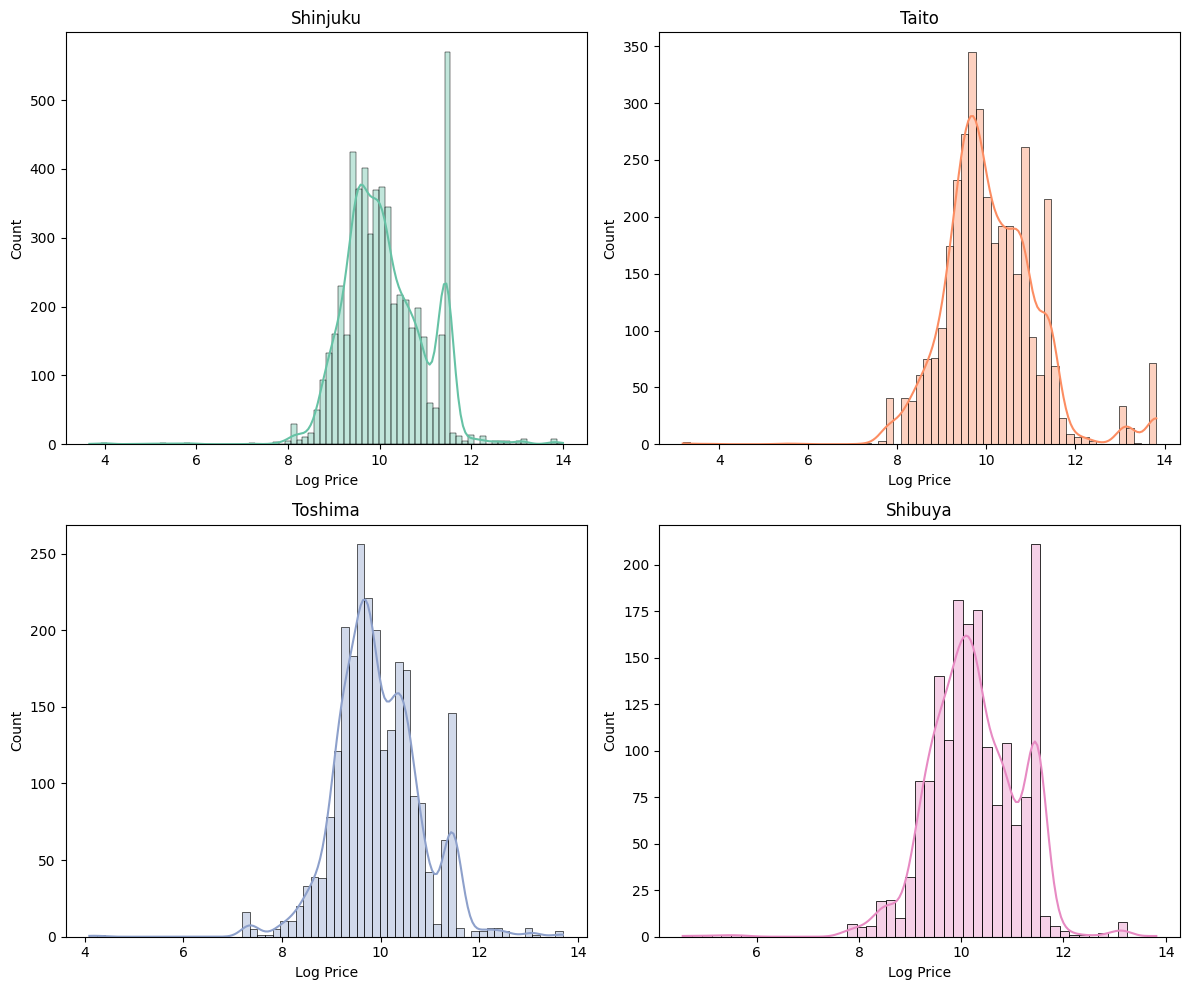

In [74]:
# Get the top 4 neighborhoods with the most counts
top_neighbourhoods = plot_df['tidied_neighbourhood'].value_counts().head(4).index


# Filter data for only the top 4 neighborhoods
filtered_df = plot_df[plot_df['tidied_neighbourhood'].isin(top_neighbourhoods)]

top_neighbourhood_names = filtered_df['tidied_neighbourhood'].unique()
# Create a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid

# Make palette
palette = sns.color_palette("Set2", n_colors=4)

# Iterate through each neighborhood and corresponding subplot
for ax, (neighbourhood, color) in zip(axes.flatten(), zip(top_neighbourhoods, palette)):
    sns.histplot(
        data=filtered_df[filtered_df['tidied_neighbourhood'] == neighbourhood],
        x="log_price",
        alpha=0.4,
        kde=True,
        color=color,  # Assign color from the palette
        ax=ax
    )
    ax.set_title(f"{neighbourhood}")
    ax.set_xlabel("Log Price")
    ax.set_ylabel("Count")

# Adjust layout for better spacing and save
plt.tight_layout()
plt.savefig(f"{get_root_dir()}/data/image2.png")
plt.show()

### 1.2.6 - All Numerical Variables

In [75]:
# Fetch numerical variables by looking at the types
types_df = list_df.dtypes.reset_index()
types_df.columns = ["col","type"]
types_df["type"] = types_df["type"].astype(str)

In [76]:
# Subset for the numerical types
num_vars = types_df[types_df["type"].apply(lambda x : True if ("int" in x or "float" in x) else False)]

In [77]:
# Calculate NaN rates for eacH
num_vars["na_rate"] = num_vars["col"].apply(lambda x : list_df[x].isna().mean())

/tmp/ipykernel_606/2513828790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_vars["na_rate"] = num_vars["col"].apply(lambda x : list_df[x].isna().mean())


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 [Text(0, 0, 'neighbourhood_group_cleansed'),
  Text(1, 0, 'calendar_updated'),
  Text(2, 0, 'bathrooms'),
  Text(3, 0, 'review_scores_value'),
  Text(4, 0, 'review_scores_location'),
  Text(5, 0, 'review_scores_communication'),
  Text(6, 0, 'review_scores_cleanliness'),
  Text(7, 0, 'review_scores_checkin'),
  Text(8, 0, 'review_scores_accuracy'),
  Text(9, 0, 'review_scores_rating'),
  Text(10, 0, 'reviews_per_month'),
  Text(11, 0, 'bedrooms'),
  Text(12, 0, 'beds'),
  Text(13, 0, 'minimum_minimum_nights'),
  Text(14, 0, 'minimum_maximum_nights'),
  Text(15, 0, 'minimum_nights_avg_ntm'),
  Text(16, 0, 'maximum_maximum_nights'),
  Text(17, 0, 'maximum_nights_avg_ntm'),
  Text(18, 0, 'maximum_minimum_nights'),
  Text(19, 0, 'host_total_listings_count'),
  Te

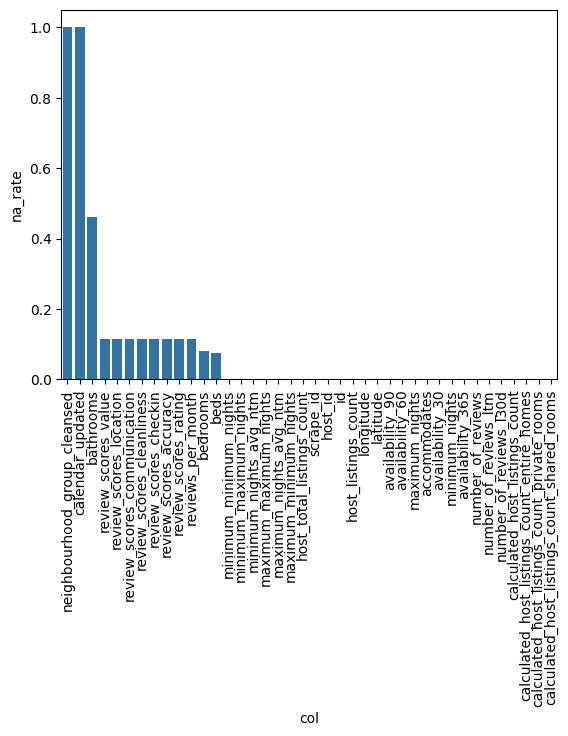

In [78]:
# Plot NaN rates
sns.barplot(data=num_vars.sort_values(by="na_rate",ascending=False),y="na_rate",x="col")
plt.xticks(rotation=90)

In [79]:
# Get list of columns
num_var_cols = num_vars["col"].values

In [80]:
# Merge each with average prices and drop id col
corr_df = pd.merge(left=list_df[num_var_cols],right=average_prices.rename(columns={"listing_id" : "id"}),how="inner",on="id")
corr_df.drop(columns=["id"],inplace=True)

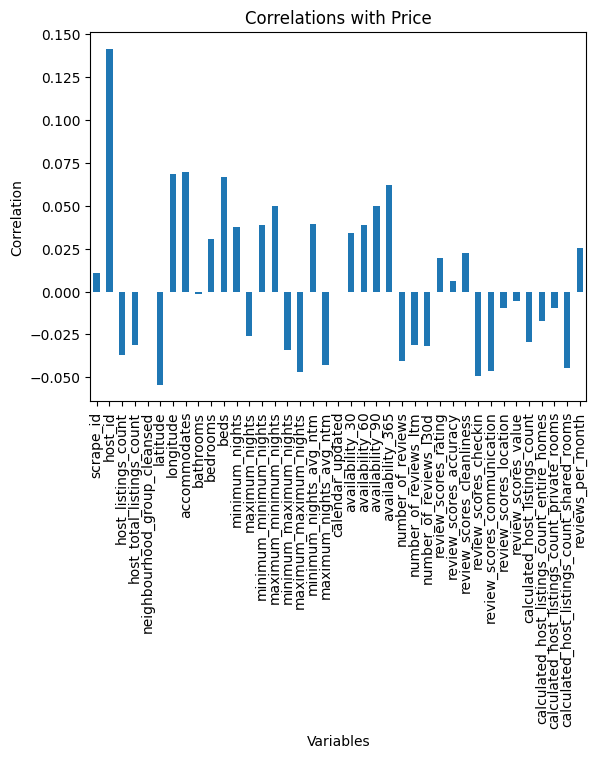

In [81]:
# Compute correlations
correlations = corr_df.corr()['price_num'].drop('price_num')  # Exclude price

# Plot bar chart
correlations.plot(kind='bar', title='Correlations with Price')
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.show()

### 1.2.6 - All Categorical Variables

In [82]:
# Reverse of the num_vars condition
cat_vars = types_df[types_df["type"].apply(lambda x : False if ("int" in x or "float" in x) else True)]

In [83]:
# Example values for a given row
for col in cat_vars["col"].values:
    print(f"""
    {col}
    {list_df[col].sample(n=1,random_state=42).iloc[0]}
    """)


    listing_url
    https://www.airbnb.com/rooms/961329853200694267
    

    last_scraped
    2024-06-29
    

    source
    city scrape
    

    name
    10ppl/163㎡/Add ppl/Nearairport
    

    description
    Thank you for visiting our listing Sleep Mai?★<br />Sleep Mai? is offers affordable and comfortable accommodation!<br />By all means,pls enjoy a fun time in Kamata,the city closest to the world and the city with the second largest number of restaurants after Shinjuku.
    

    neighborhood_overview
    nan
    

    picture_url
    https://a0.muscache.com/pictures/miso/Hosting-961147608137376961/original/d0e0c8c4-3080-467f-966c-15cc22150ada.jpeg
    

    host_url
    https://www.airbnb.com/users/show/40238920
    

    host_name
    Shigeru
    

    host_since
    2015-08-01
    

    host_location
    Tokyo, Japan
    

    host_about
    何かお困りごとがありましたらairbnbのメッセージを通してご連絡ください！
よろしくお願いします。
    

    host_response_time
    within a few hours
    

    host_response_rate
 

In [84]:
# Which fields are redundant i.e. links or names, non-comparable data or free-text?
redundant_fields = ["listing_url",
                    "name"
                    "source",
                    "description",
                    "host_url",
                    "host_name",
                    "host_about",
                    "host_thumbnail_url",
                    "host_picture_url",
                    "license",
                    "picture_url",
                    "name",
                    "neighborhood_overview",
                    "last_scraped",
                   "first_review",
                   "last_review",
                   "calendar_last_scraped",
                    "host_since",
                    "price",
                    "amenities"
                   ]

In [85]:
# Filter out redundant fields
cat_cols = cat_vars[cat_vars["col"].apply(lambda x : True if x not in redundant_fields else False)]

In [86]:
# Verify results
cat_cols

,col,type
4,source,object
13,host_location,object
15,host_response_time,object
16,host_response_rate,object
17,host_acceptance_rate,object
18,host_is_superhost,object
21,host_neighbourhood,object
24,host_verifications,object
25,host_has_profile_pic,object
26,host_identity_verified,object


In [87]:
# Turn to numerical columns
cat_df = pd.get_dummies(list_df[["price"] + cat_cols["col"].to_list()], columns=cat_cols["col"].to_list(),drop_first=True)

In [88]:
cat_df

,price,source_previous scrape,"host_location_Adachi, Japan","host_location_Akiruno, Japan","host_location_Akishima, Japan","host_location_Amami, Japan","host_location_Aoba Ward, Japan","host_location_Aomori, Japan","host_location_Arakawa City, Japan","host_location_Arakawa, Japan",...,bathrooms_text_8 baths,bathrooms_text_8 shared baths,bathrooms_text_8.5 baths,bathrooms_text_9 baths,bathrooms_text_9 shared baths,bathrooms_text_Half-bath,bathrooms_text_Private half-bath,bathrooms_text_Shared half-bath,has_availability_t,instant_bookable_t
0,"$11,000.00",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,"$7,208.00",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,"$23,066.00",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
3,"$16,000.00",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,"$10,000.00",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27690,"$16,000.00",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
27691,"$4,714.00",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
27692,"$13,186.00",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
27693,"$10,400.00",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True


### 1.2.7 - Running A Basic Model

In [89]:
# Remove NaNs for modelling
model_df = cat_df.dropna(subset="price")

In [90]:
print(model_df.shape)

(25982, 929)


In [91]:
# Sample table
model_df = model_df.sample(n=6000,random_state=12)

In [92]:
# Fix the price column to make it numerical
model_df["price_transformed"] = model_df["price"].apply(lambda x : float(x.replace(",","").replace("$","")))

In [93]:
# Set the X variables
X = model_df[[col for col in model_df.columns if col not in ["price","price_transformed"]]]

In [94]:
# Set the y variable
y= model_df["price_transformed"]

In [95]:
# Split up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
# Choose whether to run model or not
run_127_model = False

In [97]:
# Fit model on the training data
if run_127_model:
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R²: {r2}")

In [98]:
print("Model performs terribly!")

Model performs terribly!


## 1.3 - Cherry Blossom Data

### 1.3.1 - High Level View

In [99]:
first_bloom.head()

,site_name,currently_being_observed,1953,1954,1955,1956,1957,1958,1959,1960,...,2016,2017,2018,2019,2020,2021,2022,2023,30_year_average_1981-2010,notes
0,Wakkanai,True,1953-05-21,1954-05-17,1955-05-17,1956-05-12,1957-05-18,1958-05-23,1959-05-03,1960-05-19,...,2016-05-13,2017-05-09,2018-05-12,2019-05-07,2020-05-10,2021-05-08,2022-05-06,2023-05-03,5 13,Sargent cherry (Prunus sargentii)
1,Rumoi,False,1953-05-08,1954-05-11,1955-05-13,1956-05-08,1957-05-10,1958-05-12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Sargent cherry (Prunus sargentii)
2,Asahikawa,True,1953-05-11,1954-05-13,1955-05-09,1956-05-07,1957-05-09,1958-05-10,1959-05-08,1960-05-13,...,2016-05-03,2017-05-03,2018-04-30,2019-05-01,2020-05-03,2021-04-29,2022-04-26,2023-04-25,5 4,Sargent cherry (Prunus sargentii)
3,Abashiri,True,1953-05-24,1954-05-16,1955-05-18,1956-05-09,NaN,NaN,1959-05-03,NaN,...,2016-05-08,2017-05-05,2018-05-02,2019-05-05,2020-05-07,2021-05-06,2022-04-27,2023-04-28,5 10,Sargent cherry (Prunus sargentii)
4,Sapporo,True,1953-05-07,1954-05-04,1955-05-11,1956-05-04,1957-05-09,NaN,1959-05-05,1960-05-05,...,2016-04-25,2017-04-28,2018-04-26,2019-04-24,2020-04-30,2021-04-22,2022-04-23,2023-04-15,5 1,NaN


In [100]:
full_bloom.head()

,site_name,currently_being_observed,1953,1954,1955,1956,1957,1958,1959,1960,...,2016,2017,2018,2019,2020,2021,2022,2023,30_year_average_1981-2010,notes
0,Wakkanai,True,1953-05-30,1954-05-27,1955-05-23,1956-05-14,1957-05-22,1958-05-25,1959-05-12,1960-05-24,...,2016-05-15,2017-05-11,2018-05-15,2019-05-09,2020-05-12,2021-05-11,2022-05-09,2023-05-05,5 16,Sargent cherry (Prunus sargentii)
1,Rumoi,False,1953-05-13,1954-05-17,1955-05-16,1956-05-14,1957-05-14,1958-05-16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Sargent cherry (Prunus sargentii)
2,Asahikawa,True,1953-05-16,1954-05-18,1955-05-14,1956-05-13,1957-05-14,1958-05-15,1959-05-13,1960-05-16,...,2016-05-04,2017-05-05,2018-05-01,2019-05-04,2020-05-04,2021-05-03,2022-04-28,2023-04-28,5 7,Sargent cherry (Prunus sargentii)
3,Abashiri,True,1953-05-26,1954-05-19,1955-05-20,1956-05-13,NaN,NaN,1959-05-07,NaN,...,2016-05-10,2017-05-07,2018-05-06,2019-05-07,2020-05-09,2021-05-07,2022-04-30,2023-05-01,5 13,Sargent cherry (Prunus sargentii)
4,Sapporo,True,1953-05-14,1954-05-08,1955-05-16,1956-05-09,1957-05-13,NaN,1959-05-10,1960-05-09,...,2016-05-01,2017-05-03,2018-04-29,2019-04-29,2020-05-02,2021-04-27,2022-04-25,2023-04-21,5 6,NaN


In [101]:
# Locations covered
first_bloom["site_name"].unique()

array(['Wakkanai', 'Rumoi', 'Asahikawa', 'Abashiri', 'Sapporo',
       'Iwamizawa', 'Obihiro', 'Kushiro', 'Nemuro', 'Muroran', 'Urakawa',
       'Esashi', 'Hakodate', 'Kutchan', 'Monbetsu', 'Hiroo', 'Shinjo',
       'Aomori', 'Hachinohe', 'Akita', 'Morioka', 'Miyako', 'Sakata',
       'Yamagata', 'Sendai', 'Fukushima', 'Shirakawa', 'Onahama',
       'Wajima', 'Aikawa', 'Niigata', 'Kanazawa', 'Toyama', 'Nagano',
       'Takada', 'Utsunomiya', 'Fukui', 'Takayama', 'Matsumoto',
       'Maebashi', 'Kumagaya', 'Mito', 'Tsuruga', 'Gifu', 'Nagoya',
       'Iida', 'Kofu', 'Choshi', 'Tsu', 'Hamamatsu', 'Shizuoka',
       'Tokyo Japan', 'Owashi', 'Yokohama', 'Tateyama', 'Oshima',
       'Miyakejima', 'Hachijojima', 'Saigo', 'Matsue', 'Yonago',
       'Tottori', 'Toyooka', 'Maizuru', 'Hamada', 'Kyoto', 'Hikone',
       'Hiroshima', 'Okayama', 'Kobe', 'Osaka', 'Sumoto', 'Wakayama',
       'Shio Misaki', 'Nara', 'Matsuyama', 'Takamatsu', 'Uwajima',
       'Kochi', 'Tokushima', 'Shimonoseki', 'Mikih

In [102]:
## Compare to neighbourhoods 
neighbourhoods = list_df["neighbourhood_cleansed"].unique()
bloom_sites = first_bloom["site_name"].unique()


# Make into single strings
neighbourhoods = [neighbourhood.split()[0] for neighbourhood in list_df["neighbourhood_cleansed"].unique()]
bloom_sites = [site.split()[0] for site in first_bloom["site_name"].unique()]

# Find crossover 
intersection = set(neighbourhoods).intersection(set(bloom_sites))
print(intersection)

set()


In [103]:
# Only the 'Tokyo Japan' area covers our AirBnB data
tokyo_first_bloom = first_bloom[first_bloom["site_name"] == "Tokyo Japan"]
tokyo_full_bloom = full_bloom[full_bloom["site_name"] == "Tokyo Japan"]

In [104]:
tokyo_first_bloom

,site_name,currently_being_observed,1953,1954,1955,1956,1957,1958,1959,1960,...,2016,2017,2018,2019,2020,2021,2022,2023,30_year_average_1981-2010,notes
51,Tokyo Japan,True,1953-03-26,1954-03-26,1955-03-24,1956-03-26,1957-04-02,1958-03-30,1959-03-24,1960-03-23,...,2016-03-21,2017-03-21,2018-03-17,2019-03-21,2020-03-14,2021-03-14,2022-03-20,2023-03-14,3 24,NaN


In [105]:
tokyo_full_bloom

,site_name,currently_being_observed,1953,1954,1955,1956,1957,1958,1959,1960,...,2016,2017,2018,2019,2020,2021,2022,2023,30_year_average_1981-2010,notes
51,Tokyo Japan,True,1953-04-05,1954-04-01,1955-04-05,1956-04-08,1957-04-10,1958-04-06,1959-04-05,1960-04-01,...,2016-03-31,2017-04-02,2018-03-24,2019-03-27,2020-03-22,2021-03-22,2022-03-27,2023-03-22,3 31,NaN


In [106]:
print("Does not cover out date range, can we find the dates elswhere?")

Does not cover out date range, can we find the dates elswhere?


In [107]:
print("""Using :{https://www.jrailpass.com/blog/japan-cherry-blossom-forecast}

first bloom is 2024-03-29 and full bloom is 2024-04-04
""")

Using :{https://www.jrailpass.com/blog/japan-cherry-blossom-forecast}

first bloom is 2024-03-29 and full bloom is 2024-04-04



In [108]:
near_to_bloom_cal_df = cal_df[(pd.to_datetime(cal_df["date"]) < '2024-05-01') & (pd.to_datetime(cal_df["date"]) > '2024-02-01')]

/tmp/ipykernel_606/4222415178.py:86: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=summary_stats, x=summary_stats[datefield],y=f"log_{x}" if log_scale else 'avg',hue=group_var, linewidth=2,palette=sns_palette)
/tmp/ipykernel_606/4222415178.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


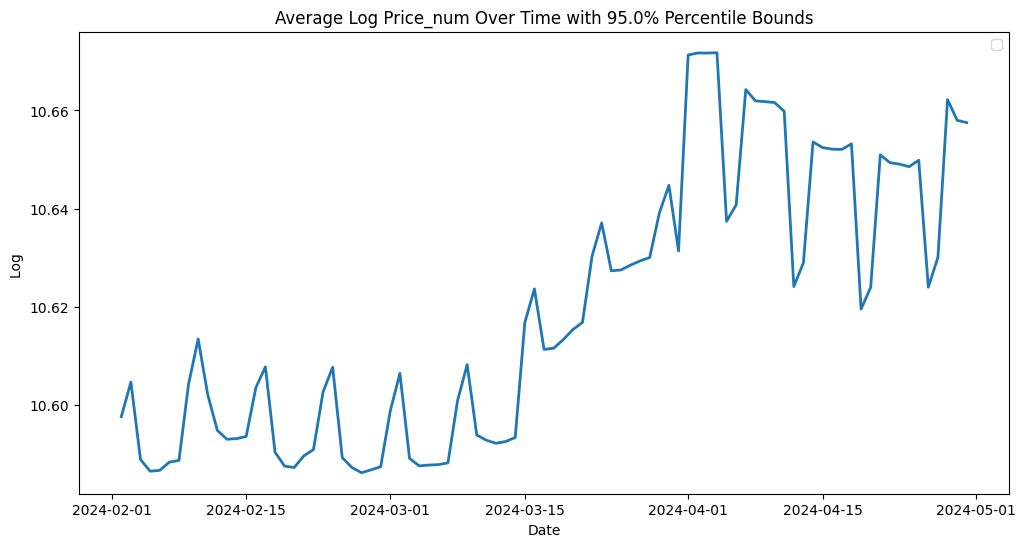

In [109]:
# Look at availability for price 
average_x_time_plot(near_to_bloom_cal_df,"date","price_num")

In [110]:
print("Seems to be a change, can we check using the Mann-Whitney U test")

Seems to be a change, can we check using the Mann-Whitney U test


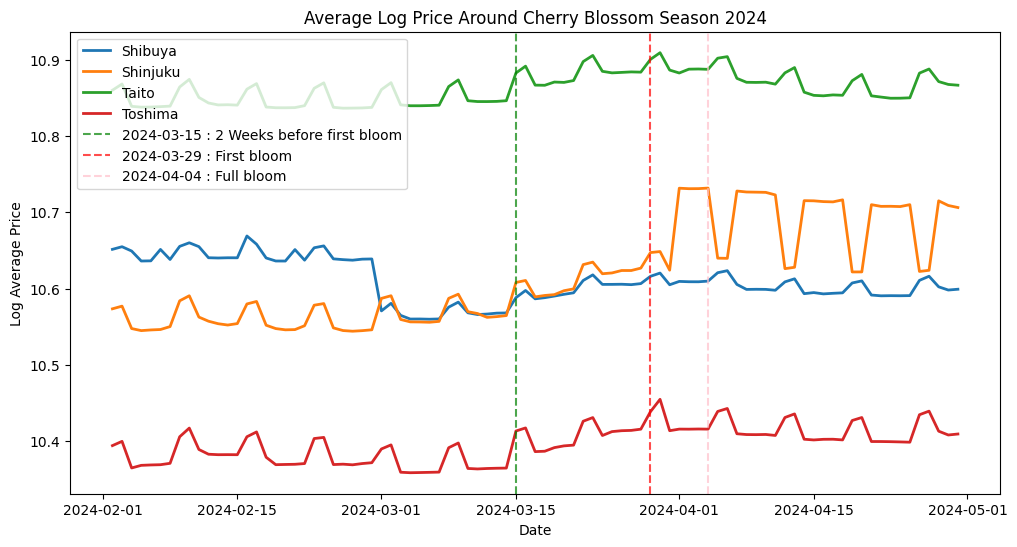

In [111]:
# Make a prettier plot for Medium

# Use logic from average x time plot function with relevant changes

# Copy dataframe to avoid making changes
work_df = near_to_bloom_cal_df.copy(deep=False)

work_df = pd.merge(left=work_df,right=list_df[["id","neighbourhood_cleansed"]].rename(columns={"id":"listing_id"}),how="inner",on="listing_id")

# Convert data column to DT format
work_df["date"] = pd.to_datetime(work_df["date"])

work_df["tidier_neighbourhood_name"] = work_df["neighbourhood_cleansed"].apply(neighbourhood_name_tider)

work_df = work_df[work_df["tidier_neighbourhood_name"].isin(top_neighbourhood_names)]

# Set grouping variables
group_fields = ["date","tidier_neighbourhood_name"]

# Get the summary stats depending on whether upper or lower bounds were wanted
summary_stats = work_df.groupby(group_fields)["price_num"].agg(avg='mean').reset_index()

# Create necessary transformed variables depending on log_scale argument 
summary_stats["log_price"] = np.log(summary_stats['avg'])


# Create plot
plt.figure(figsize=(12, 6))

# Create a palette to keep colouring of bounds consistent with the line plot
sns_palette = sns.color_palette(n_colors=summary_stats["tidier_neighbourhood_name"].nunique())

# Plot lineplot of date against (log) of average x over time
sns.lineplot(data=summary_stats, x=summary_stats["date"],y="log_price",hue="tidier_neighbourhood_name", linewidth=2,palette=sns_palette)

vline_dates = ['2024-03-15','2024-03-29','2024-04-04']
vline_colours = ['green','red','pink']
vline_labels = ['2 Weeks before first bloom','First bloom', 'Full bloom']

for index, date in enumerate(vline_dates):
    plt.axvline(pd.to_datetime(date), linestyle="--", color=vline_colours[index], alpha=0.7, label=f"{date} : {vline_labels[index]}")
    
plt.xlabel('Date')
plt.ylabel(f'Log Average Price')
plt.title(f'Average Log Price Around Cherry Blossom Season 2024')
plt.legend()
plt.savefig(f"{get_root_dir()}/data/image3.png")
plt.show()

# 2 - Answering Questions

## 2.1 - Q1

In [112]:
get_question("1")

Q1: How much do neighbourhoods affect the price of AirBnbs?


### 2.1.1 - Try A Model

In [113]:
# Take smaller sample to minimise data set size 
print(list_df["id"].nunique())

18929


In [114]:
sample_fraction = 0.1  # 10% sample from each group

# Perform stratified sampling
sampled = list_df.groupby('neighbourhood_cleansed').sample(frac=sample_fraction, random_state=42)

# Return only field id
ids = sampled['id'].to_list()

print(len(ids))

2768


In [115]:
# Get neighbourhood information
q1_df = pd.merge(left=cal_df[cal_df["listing_id"].isin(ids)].rename(columns={"listing_id" : "id"}),right=list_df[list_df["id"].isin(ids)][["id","neighbourhood_cleansed"]],how="inner",on="id")

In [116]:
# Turn neighbourhood into categorical columns 
q1_df = pd.get_dummies(q1_df,columns=["neighbourhood_cleansed"],drop_first=True,dtype=int)

In [117]:
# Remove nans for prediction variable
q1_df = q1_df.dropna(subset="price_num")

In [118]:
q1_df.head()

,id,date,available,price,adjusted_price,minimum_nights,maximum_nights,date_dt,price_num,neighbourhood_cleansed_Akiruno Shi,...,neighbourhood_cleansed_Setagaya Ku,neighbourhood_cleansed_Shibuya Ku,neighbourhood_cleansed_Shinagawa Ku,neighbourhood_cleansed_Shinjuku Ku,neighbourhood_cleansed_Suginami Ku,neighbourhood_cleansed_Sumida Ku,neighbourhood_cleansed_Tachikawa Shi,neighbourhood_cleansed_Taito Ku,neighbourhood_cleansed_Tama Shi,neighbourhood_cleansed_Toshima Ku
0,776070,2023-06-29,f,"$7,208.00","$7,208.00",3.0,14.0,2023-06-29,7208.0,0,...,0,0,0,0,0,0,0,0,0,0
1,776070,2023-06-29,f,"$7,208.00","$7,208.00",3.0,14.0,2023-06-29,7208.0,0,...,0,0,0,0,0,0,0,0,0,0
2,776070,2023-06-30,f,"$7,208.00","$7,208.00",3.0,14.0,2023-06-30,7208.0,0,...,0,0,0,0,0,0,0,0,0,0
3,776070,2023-06-30,f,"$7,208.00","$7,208.00",3.0,14.0,2023-06-30,7208.0,0,...,0,0,0,0,0,0,0,0,0,0
4,776070,2023-07-01,f,"$7,208.00","$7,208.00",3.0,14.0,2023-07-01,7208.0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
q1_df.shape

(2830926, 53)

In [120]:
# Remove prices of 0 before logging 
q1_df = q1_df[q1_df["price_num"] > 0]

In [121]:
# Check shape
q1_df.shape

(2830926, 53)

In [122]:
# Isolate neighbourhood dummy variables
predictive_variables = [col for col in q1_df.columns if "neighbourhood_cleansed" in col]

In [123]:
# Drop duplicates for variables of interest to reduce size of dataset
pre_df = q1_df[["price_num"] + predictive_variables].drop_duplicates()

In [124]:
pre_df.shape

(13196, 45)

In [125]:
# Subset predictive variables
X = pre_df[predictive_variables]

In [126]:
# Take log of price
y = np.log(pre_df["price_num"])

In [127]:
X.shape

(13196, 44)

In [128]:
y.shape

(13196,)

In [129]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [130]:
# Fit model
neighbourhood_model = LinearRegression()
neighbourhood_model.fit(X_train, y_train)

LinearRegression()

In [131]:
# Predict for y based on X test data
y_pred = neighbourhood_model.predict(X_test)

In [132]:
# Calculate meaningful measures of model success (found these as an idea through StackExchange)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")

MAE: 0.6494098558270268
MSE: 0.7053382210260745
R²: 0.12885103299759537


In [133]:
print("It predicts better than expected but still not the end of the matter when determining the price of a property")

It predicts better than expected but still not the end of the matter when determining the price of a property


## 2.2 - Q2

In [134]:
get_question("2")

Q2: 花見 (hanami) is the Japanese practice of watching cherry blossoms bloom, in Japan due to a previous blight among the tree population around 80% of cherry blossoms are genetically identical meaning the vast majority will bloom under the same conditions. Forecasts exist and are well known, for the date of mass blooming. Does the date of blooming seem to impact the price?


### 2.2.1 - Performing Significance Test

In [135]:
# Divide time data into before and after cherry blossom bloom (allow 2 weeks to account for people booking before hand not just on the day)
pre_bloom_prices = np.log(near_to_bloom_cal_df[pd.to_datetime(near_to_bloom_cal_df["date"]) < '2024-03-15']["price_num"])
post_bloom_prices = np.log(near_to_bloom_cal_df[pd.to_datetime(near_to_bloom_cal_df["date"]) >= '2024-03-29']["price_num"])

In [136]:
print(len(pre_bloom_prices),len(post_bloom_prices))

469308 368742


In [137]:
print(len(set(pre_bloom_prices).intersection(post_bloom_prices)))

1796


In [138]:
# Run statistical test (discovered from Wikipedia)
stat, p_value = mannwhitneyu(pre_bloom_prices, post_bloom_prices, alternative='less')

In [139]:
# Output the results
print(f"U statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("Significant difference between the groups (reject null hypothesis).")
else:
    print("No significant difference between the groups (fail to reject null hypothesis).")

U statistic: 84974303290.5
P-value: 1.2576497730313926e-45
Significant difference between the groups (reject null hypothesis).


In [140]:
print("Seems there is a significant difference!")

Seems there is a significant difference!


## 2.3 - Q3 

In [141]:
get_question("3")

Q3: Which features of the dataset have the best predictive power for the price of a propert based on logistic regression?


### 2.3.1 - Decide on features to test best on EDA

In [142]:
# Which fields are redundant i.e. links or names, non-comparable data or free-text?
redundant_fields = ["id",
                    "listing_url",
                    "latitude",
                    "longitude",
                    "scrape_id",
                    "source",
                    "host_id",
                    "neighbourhood",
                    "neighbourhood_group_cleansed",
                    "name",
                    "source",
                    "description",
                    "host_url",
                    "host_name",
                    "host_about",
                    "host_thumbnail_url",
                    "host_picture_url",
                    "license",
                    "picture_url",
                    "name",
                    "neighborhood_overview",
                    "last_scraped",
                   "first_review",
                   "last_review",
                   "calendar_last_scraped",
                    "host_since",
                    "amenities",
                    "bathrooms_text",
                    "minimum_minimum_nights",
                    "maximum_minimum_nights",
                    'availability_30', 'availability_60', 'availability_90',
       'availability_365',
                    'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms',
                    "host_total_listings_count",
                    'number_of_reviews_ltm', 'number_of_reviews_l30d',
                    "host_location",
                    "host_listings_count",
                    'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', "has_availability"
                    
                   ]

In [143]:
# Drop redundant fields
q3_df = list_df[[col for col in list_df.columns if col not in redundant_fields]]

In [144]:
# Check columns
q3_df.columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month'],
      dtype='object')

In [145]:
# Format price into a number
q3_df["price_num"] = q3_df["price"].apply(lambda x : float(str(x).replace("$", "").replace(",","")))

/tmp/ipykernel_606/1262626922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q3_df["price_num"] = q3_df["price"].apply(lambda x : float(str(x).replace("$", "").replace(",","")))


In [146]:
# Remove nums and drop original price column
q3_df = q3_df.dropna(subset="price_num")
q3_df = q3_df[q3_df["price_num"] > 0]
q3_df = q3_df[[col for col in q3_df.columns if col != "price"]]

<Axes: >

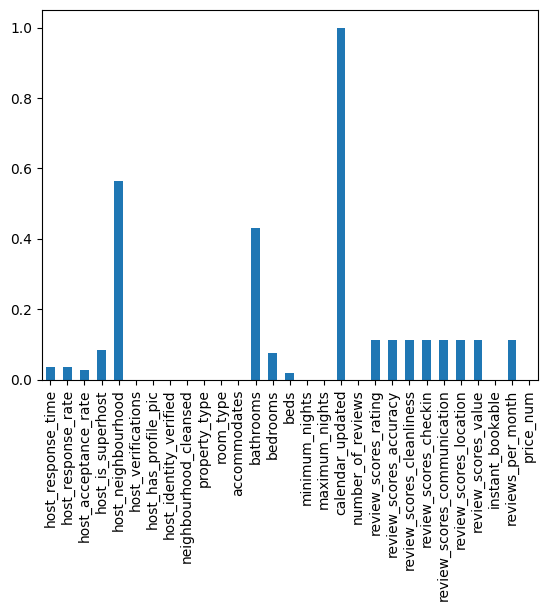

In [147]:
q3_df.isna().mean().plot(kind="bar")

In [148]:
# Drop columns with other 50% nans
q3_df = q3_df[[col for col in q3_df.columns if q3_df[col].isna().mean() < 0.5]]

<Axes: >

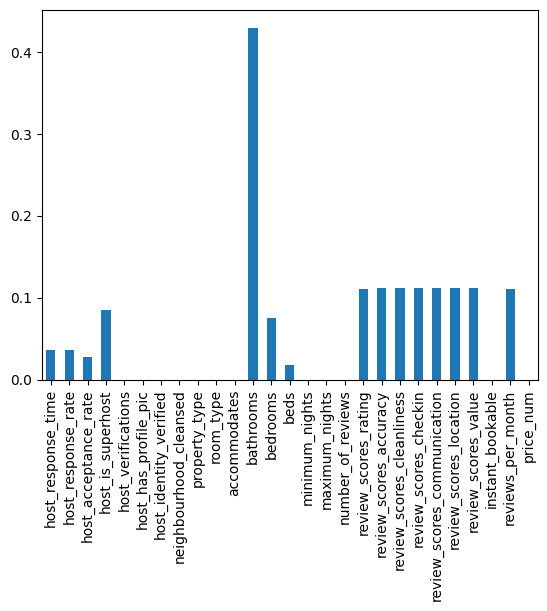

In [149]:
# Verify the drop
q3_df.isna().mean().plot(kind="bar")

In [150]:
# Check shape
q3_df.shape

(25981, 27)

In [151]:
features=q3_df.columns

In [152]:
# Get types
types_df = q3_df.dtypes.reset_index().rename(columns={"0" : "type"})
types_df.columns = ["col","type"]

In [153]:
# Make type field a string for easier filtering
types_df["type"] = types_df["type"].astype(str)

In [154]:
# Filter for ints and floats
num_types = types_df[types_df["type"].isin(["float64","int64"])]

In [155]:
num_types

,col,type
10,accommodates,int64
11,bathrooms,float64
12,bedrooms,float64
13,beds,float64
14,minimum_nights,int64
15,maximum_nights,int64
16,number_of_reviews,int64
17,review_scores_rating,float64
18,review_scores_accuracy,float64
19,review_scores_cleanliness,float64


In [156]:
# Reverse condition to get non numerical types
non_num_types = types_df[~(types_df["type"].isin(["float64","int64"]))]

In [157]:
non_num_types

,col,type
0,host_response_time,object
1,host_response_rate,object
2,host_acceptance_rate,object
3,host_is_superhost,object
4,host_verifications,object
5,host_has_profile_pic,object
6,host_identity_verified,object
7,neighbourhood_cleansed,object
8,property_type,object
9,room_type,object


In [158]:
# Verify we haven't missed any numeric columns
# Change the column as necessary
col_to_check = "instant_bookable"

display(q3_df[col_to_check].value_counts())

instant_bookable
t    19038
f     6943
Name: count, dtype: int64

In [159]:
# Columns that are numerical but just formated as strings
missed_nums = ["host_response_rate","host_acceptance_rate"]

In [160]:
# Apply processing to make them numerical
for col in missed_nums:
    q3_df[col] = q3_df[col].str.replace("%", "").apply(pd.to_numeric, errors='coerce') / 100

### 2.3.2 - Preprocess Data

In [161]:
# List numerical columns
num_cols = list(num_types["col"]) + missed_nums

In [162]:
# Get numerical columns and drop target variable
num_df = q3_df[[col for col in num_cols if col != "price_num"]]

In [163]:
# Scale each column to allow easier cross comparison
scaler = StandardScaler()
num_df[num_df.columns] = scaler.fit_transform(num_df)

/tmp/ipykernel_606/2608689629.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df[num_df.columns] = scaler.fit_transform(num_df)


In [164]:
# Get categorical columns and drop actual numerical columns
cat_df = q3_df[[col for col in list(non_num_types["col"].unique()) if col not in missed_nums and col != "price_num"]]

In [165]:
cat_df

,host_response_time,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,instant_bookable
0,within a few hours,t,"['email', 'phone']",t,t,Sumida Ku,Entire rental unit,Entire home/apt,f
1,within an hour,NaN,"['email', 'phone']",t,t,Kita Ku,Private room in home,Private room,f
2,within an hour,t,"['email', 'phone']",t,t,Shibuya Ku,Entire rental unit,Entire home/apt,t
3,within an hour,NaN,"['email', 'phone']",t,t,Setagaya Ku,Private room in home,Private room,f
4,within a few hours,NaN,"['email', 'phone']",t,t,Adachi Ku,Private room in home,Private room,f
...,...,...,...,...,...,...,...,...,...
27690,within an hour,t,"['email', 'phone']",t,t,Shibuya Ku,Entire rental unit,Entire home/apt,t
27691,NaN,f,"['email', 'phone']",t,t,Itabashi Ku,Entire rental unit,Entire home/apt,t
27692,within an hour,f,"['email', 'phone']",t,t,Ota Ku,Entire home,Entire home/apt,t
27693,NaN,f,"['email', 'phone']",t,t,Sumida Ku,Entire rental unit,Entire home/apt,t


In [166]:
cat_features = cat_df.columns

In [167]:
cat_features

Index(['host_response_time', 'host_is_superhost', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type',
       'instant_bookable'],
      dtype='object')

In [168]:
# Join (sideways) to make full dataframe
processed_df = pd.concat([cat_df,num_df],axis=1)

In [169]:
processed_df.head()

,host_response_time,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,instant_bookable,accommodates,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_response_rate,host_acceptance_rate
0,within a few hours,t,"['email', 'phone']",t,t,Sumida Ku,Entire rental unit,Entire home/apt,f,-0.786453,...,0.276111,0.033908,0.658652,0.253708,0.076910,-0.505428,0.453721,-0.263961,0.178618,-1.161214
1,within an hour,NaN,"['email', 'phone']",t,t,Kita Ku,Private room in home,Private room,f,-1.128397,...,0.852560,0.721854,0.658652,0.694304,0.608327,0.467845,0.796858,0.143596,0.178618,0.351238
2,within an hour,t,"['email', 'phone']",t,t,Shibuya Ku,Entire rental unit,Entire home/apt,t,0.581321,...,0.218466,0.158989,0.211431,0.348121,0.324905,0.273190,0.396532,-0.096143,0.178618,0.351238
3,within an hour,NaN,"['email', 'phone']",t,t,Setagaya Ku,Private room in home,Private room,f,-0.786453,...,0.737271,0.628043,0.395581,0.568420,0.608327,0.759827,0.739668,0.185550,0.178618,-0.026875
4,within a few hours,NaN,"['email', 'phone']",t,t,Adachi Ku,Private room in home,Private room,f,-0.102566,...,0.074354,0.440422,0.211431,0.505477,0.254049,-0.051234,0.339342,-0.515687,0.178618,-5.950646


In [170]:
print(q3_df.shape)

(25981, 27)


In [172]:
# Check for NaNs
processed_df.isna().sum()

host_response_time               928
host_is_superhost               2216
host_verifications                 0
host_has_profile_pic               0
host_identity_verified             0
neighbourhood_cleansed             0
property_type                      0
room_type                          0
instant_bookable                   0
accommodates                       0
bathrooms                      11178
bedrooms                        1940
beds                             475
minimum_nights                     0
maximum_nights                     0
number_of_reviews                  0
review_scores_rating            2884
review_scores_accuracy          2903
review_scores_cleanliness       2903
review_scores_checkin           2903
review_scores_communication     2903
review_scores_location          2904
review_scores_value             2905
reviews_per_month               2884
host_response_rate               928
host_acceptance_rate             731
dtype: int64

### 2.3.3 - Run Linear Regression and RFE

In [173]:
def random_feature_elimination(df, features, categorical_features, target,rand_try_max=100, random_state=42, frac=1):
    """
    Perform random feature elimination to evaluate the predictive power of random feature subsets 
    using Linear Regression with regression metrics.

    Parameters:
    ----------
    df : pandas.DataFrame
        The dataset containing the features and target variable.
    features : list
        A list of feature column names to sample from.
    categorical_features : list
        A list of feature column names that are categorical and need to be encoded.
    target : str
        The name of the target column.
    rand_try_max : int, optional (default=100)
        The maximum number of random feature combinations to evaluate.
    random_state : int, optional (default=42)
        A seed to ensure reproducibility of the random sampling.
    frac : float, optional (default=1)
        The fraction of the data to sample for training and testing.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame containing:
        - 'features': The randomly selected set of features used in each trial.
        - 'MAE': The Mean Absolute Error of the Linear Regression model for that feature set.
        - 'MSE': The Mean Squared Error of the Linear Regression model for that feature set.
        - 'R²': The coefficient of determination (R² score) of the Linear Regression model for that feature set.

    Notes:
    -----
    - This function samples 5 random features at a time, ensuring no duplicate combinations are tested.
    - Linear Regression is used to evaluate the predictive power of each feature subset.
    - Missing values in categorical features are replaced with a placeholder value, and missing values in 
      numerical features are replaced with -1.
    - Categorical features are numericlly encoded before model training.
    - A progress bar is displayed to track the completion of iterations using tqdm.
    - Results are sorted by the R² score in descending order.
    - All numeric values in the output DataFrame are formatted to 10 decimal places to be more readable than e notation.
    """
    np.random.seed(random_state)
    
    # Sample data
    sample = df.sample(frac=frac,random_state=random_state)

    X = sample[features]
    y = sample[target]
    
   
    X, y = X.align(y, join='inner', axis=0)  # Ensure alignment

    

    # Store the results in this list, we can use a set to check whether a random combination of features has already been done
    results = []
    checked_sets = set()

    # Loop over random trials with progress bar
    for i in tqdm(range(rand_try_max), desc="Progress"):
        
        # Randomly select 5 features
        selected_features = tuple(np.random.choice(features, size=5, replace=False))

        # Skip if this feature combination has been checked
        if selected_features in checked_sets:
            continue
        checked_sets.add(selected_features)

        # Reduce features to just those selected
        X_reduced = X[list(selected_features)]

        # Check if any features are categorical or not
        selected_cat_features = [str(feature) for feature in list(selected_features) if feature in categorical_features]

        # Fill missing values in categorical features with a placeholder before doing dummy mapping
        X_reduced[selected_cat_features] = X_reduced[selected_cat_features].fillna("PLACEHOLDER")
        
        # Fill missing values in non-categorical features with -1 to make distinct
        non_cat_features = [col for col in X_reduced.columns if col not in selected_cat_features]
        X_reduced[non_cat_features] = X_reduced[non_cat_features].fillna(-1)
        
        # Ensure categorical features are properly encoded as numbers
        if len(selected_cat_features) >= 1:
            X_reduced = pd.get_dummies(X_reduced, columns=selected_cat_features, drop_first=True, dtype=int)
            
        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=random_state)
        
        # Train linear regression
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Evaluate model
        y_pred = model.predict(X_test)
        mae = float(mean_absolute_error(y_test, y_pred))
        mse = float(mean_squared_error(y_test, y_pred))
        r2 = float(r2_score(y_test, y_pred))
        
        # Store result
        results.append({
            'features': selected_features,
            'MAE': mae,
            'MSE': mse,
            'R²': r2
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False)

    # Format DataFrame as strings with decimals
    formatted_df = results_df.applymap(lambda x: f"{x:.10f}" if isinstance(x, float) else x)
    return formatted_df


In [174]:
# Get the features for the model
features=processed_df.columns

In [175]:
# processed_df is missing price_num so it is the X for this (even if this X is not an argument for the function)
X = processed_df

In [176]:
# Get y (log for better linear regression)
y = np.log(q3_df["price_num"])

In [177]:
# Add price to get a single dataframe with everything we need 
df = pd.concat([X,y],axis=1)

In [178]:
# Assert features doesn't have the target var
features = [col for col in df.columns if col != "price_num"]
target = "price_num"

In [179]:
# Remove warnings as the slice warnings block the outputs too much
import warnings

warnings.filterwarnings("ignore")

# Fetch results
results = random_feature_elimination(df,features,cat_features,target)

Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.40it/s]


In [180]:
# Show results
results

,features,MAE,MSE,R²
89,"(property_type, accommodates, host_response_ti...",0.3931557298,0.2870551249,0.4489313476
11,"(property_type, review_scores_location, accomm...",0.3909514268,0.2886861844,0.4458001520
12,"(neighbourhood_cleansed, review_scores_communi...",0.3831739439,0.2891197514,0.4449678199
27,"(number_of_reviews, accommodates, property_typ...",0.3942593464,0.2910123927,0.4413344575
67,"(host_has_profile_pic, property_type, review_s...",0.3944634895,0.2911717789,0.4410284790
...,...,...,...,...
16,"(host_identity_verified, bathrooms, host_respo...",0.5588216209,0.5175290618,0.0064833619
36,"(host_response_rate, review_scores_accuracy, r...",0.5575575177,0.5183109067,0.0049824299
41,"(host_has_profile_pic, reviews_per_month, revi...",0.5580218446,0.5184332720,0.0047475215
84,"(number_of_reviews, review_scores_communicatio...",0.5595624476,0.5190672927,0.0035303722


In [181]:
# Get top 5 feature combos 
for feature in results["features"].head():
    print(feature)

(np.str_('property_type'), np.str_('accommodates'), np.str_('host_response_time'), np.str_('room_type'), np.str_('host_is_superhost'))
(np.str_('property_type'), np.str_('review_scores_location'), np.str_('accommodates'), np.str_('host_is_superhost'), np.str_('beds'))
(np.str_('neighbourhood_cleansed'), np.str_('review_scores_communication'), np.str_('beds'), np.str_('accommodates'), np.str_('bedrooms'))
(np.str_('number_of_reviews'), np.str_('accommodates'), np.str_('property_type'), np.str_('host_is_superhost'), np.str_('review_scores_value'))
(np.str_('host_has_profile_pic'), np.str_('property_type'), np.str_('review_scores_location'), np.str_('minimum_nights'), np.str_('accommodates'))


In [182]:
# Estimate MAE in original Yen
mae_log = 0.3931557298
mean_X = np.mean(q3_df["price_num"])

# Convert MAE to the original scale using estimation formula
relative_error = np.exp(mae_log) - 1
mae_original = relative_error * mean_X

print(f"MAE estimate on the original scale: {mae_original}")


MAE estimate on the original scale: 10195.354466907367


## 2.4 - Q4

In [183]:
print(get_question("4"))

Q4 : What are the features that best predict superhost status?
None


### 2.4.1 - Write a Function to do Feature Elimination for Logistic Regression

In [184]:
# We can use the same initial dataset as before but just alter the model to be logistic regression, we can just rewrite the previous function

In [185]:
def random_feature_elimination_logistic(df, features, categorical_features, target, rand_try_max=100, random_state=42, frac=1, fillna=False):
    """
    Perform random feature elimination to evaluate the predictive power of random feature subsets 
    using Logistic Regression with classification metrics.

    Parameters:
    ----------
    df : pandas.DataFrame
        The dataset containing the features and target variable.
    features : list
        A list of feature column names to sample from.
    categorical_features : list
        A list of feature column names that are categorical and need to be encoded.
    target : str
        The name of the target column.
    rand_try_max : int, optional (default=100)
        The maximum number of random feature combinations to evaluate.
    random_state : int, optional (default=42)
        A seed to ensure reproducibility of the random sampling.
    frac : float, optional (default=1)
        The fraction of the data to sample for training and testing.
    fillna : bool, optional (default=False)
        Whether to fill missing values in the data.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame containing:
        - 'features': The randomly selected set of features used in each trial.
        - 'accuracy': Measures the accuracy of the model in predicting the binary (Superhost) status

    Notes:
    -----
    - This function samples 5 random features at a time, ensuring no duplicate combinations are tested.
    - Logistic Regression is used to evaluate the predictive power of each feature subset.
    - Missing values in categorical features are replaced with a placeholder value, and missing values in 
      numerical features are replaced with -1 if fillna=True.
    - Categorical features are numerically encoded before model training.
    - A progress bar is displayed to track the completion of iterations.
    - Results are sorted by the accuracay score in descending order.
    - All numeric values in the output DataFrame are formatted to 10 decimal places.
    """
    np.random.seed(random_state)
    
    # Sample data
    sample = df.sample(frac=frac, random_state=random_state)

    X = sample[features]
    y = sample[target]
    
    # Ensure alignment
    X, y = X.align(y, join='inner', axis=0)

    # Make list for the results and make a set to check if feature combination has been done before
    results = []
    checked_sets = set()

    # Loop over random trials with task bar for progress
    for i in tqdm(range(rand_try_max), desc="Progress"):
        # Randomly select 5 features
        selected_features = tuple(np.random.choice(features, size=5, replace=False))

        # Skip if this feature combination has been checked
        if selected_features in checked_sets:
            continue
        checked_sets.add(selected_features)

        # Reduce features to the selected ones
        X_reduced = X[list(selected_features)]

        # Check if any features are categorical or not
        selected_cat_features = [str(feature) for feature in list(selected_features) if feature in categorical_features]

        if fillna:
            # Fill missing values in categorical features
            X_reduced[selected_cat_features] = X_reduced[selected_cat_features].fillna("PLACEHOLDER")
            
            # Fill missing values in non-categorical features
            non_cat_features = [col for col in X_reduced.columns if col not in selected_cat_features]
            X_reduced[non_cat_features] = X_reduced[non_cat_features].fillna(-1)

        # Ensure categorical features are properly encoded
        if len(selected_cat_features) >= 1:
            X_reduced = pd.get_dummies(X_reduced, columns=selected_cat_features, drop_first=True, dtype=int)
            
        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=random_state)
        
        # Train logistic regression
        model = LogisticRegression()
        model.fit(X_train, y_train)

        # Evaluate model
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        # Store result
        results.append({
            'features': selected_features,
            'accuracy' : accuracy
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results).sort_values(by='accuracy', ascending=False)

    # Format DataFrame as strings with decimals
    formatted_df = results_df.applymap(lambda x: f"{x:.10f}" if isinstance(x, float) else x)
    return formatted_df

### 2.4.2 - Process Data for Superhost Run

In [186]:
# New target variable for Q4
new_target = "host_is_superhost"

In [187]:
# Bring price_num back in as a potential model feature for this run
superhost_df = pd.concat([processed_df,q3_df["price_num"]],axis=1)

In [188]:
# Define this model's features
features = [col for col in superhost_df.columns if (col != new_target) and (col != new_target)]

In [189]:
# Convert superhost status to a integer boolean for better implementationn
def superhost_map(x):
    if x == 't':
        return 1
    elif x == 'f':
        return 0
    else:
        None

In [190]:
superhost_df.shape

(25981, 27)

In [191]:
superhost_df[new_target] = superhost_df[new_target].apply(superhost_map)

In [192]:
superhost_df.dropna(subset=new_target,inplace=True)

In [193]:
superhost_df.shape

(23765, 27)

### 2.4.3 - Get results

In [194]:
results_super = random_feature_elimination_logistic(superhost_df,features,cat_features,new_target,fillna=True)

Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.73it/s]


In [195]:
results_super.head()

,features,accuracy
66,"(review_scores_location, host_acceptance_rate,...",0.7096570587
53,"(minimum_nights, review_scores_rating, room_ty...",0.7075531243
43,"(review_scores_rating, bedrooms, number_of_rev...",0.7052387965
41,"(host_identity_verified, host_response_rate, r...",0.7041868294
80,"(host_response_rate, reviews_per_month, review...",0.7035556491


In [196]:
for feature in results_super["features"].head():
    print(feature)

(np.str_('review_scores_location'), np.str_('host_acceptance_rate'), np.str_('host_response_time'), np.str_('review_scores_rating'), np.str_('room_type'))
(np.str_('minimum_nights'), np.str_('review_scores_rating'), np.str_('room_type'), np.str_('number_of_reviews'), np.str_('review_scores_cleanliness'))
(np.str_('review_scores_rating'), np.str_('bedrooms'), np.str_('number_of_reviews'), np.str_('host_response_rate'), np.str_('neighbourhood_cleansed'))
(np.str_('host_identity_verified'), np.str_('host_response_rate'), np.str_('review_scores_cleanliness'), np.str_('review_scores_rating'), np.str_('review_scores_communication'))
(np.str_('host_response_rate'), np.str_('reviews_per_month'), np.str_('review_scores_rating'), np.str_('bedrooms'), np.str_('review_scores_checkin'))
